# Youtube Trend Analysis
##### Team Members: Desiree Herschberger, William Pappas, Thomas Keane, Tas Nahar, Redeat Bekele, Sveena Sharma

In [363]:
%matplotlib notebook
%matplotlib inline

In [364]:
# Load packages
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
import functools as ft
import seaborn as sns
import re  
from scipy.stats import logistic
import calendar
import random
import json

In [365]:
# Load data 
youtube_data = pd.read_csv('YouTube_Data/US_youtube_trending_data.csv')
lookup = pd.read_csv('YouTube_Data/category_ids.csv')

# Data Cleaning and Exploration
#### Pandas Process

* Parse youtube date format into datetime format
* Calculate lag time for each video to trend
* Replace category ID integers with category names based on youtube category dictionary
* Sort by ‘like’, most to least
* Drop duplicates
* Groupby date, calculate number of trending videos published
* Groupby category calculate number, like %, dislike %
* Groupby month, see if there are trending difference month-to-month (there are not)
* Analyze the lag time for a video to trend

In [366]:
# Function to parse dates (there is probably a built-in function, but this is what I was able to figure out)

def youtube_date_parse(df, series_to_parse, new_name_date, new_name_time, delimiting_character, drop_character):
    try:
        split = df[series_to_parse].str.split(delimiting_character, n = 1, expand = True)
        split[1] =split[1].map(lambda x: x.rstrip(drop_character))
        df[new_name_date] = split[0]
        df[new_name_time] = split[1]
        df.drop(columns = [series_to_parse], inplace=True)
        df[new_name_date] = pd.to_datetime(df[new_name_date])
        return df
    except:
        print('Already parsed, dumbass...')

In [367]:
########### Clean up data: drop columns, parse dates, replace category numbers with cateogry names, etc. #####

# Drop unneeded columns
youtube_data.drop(['video_id','channelId', 'thumbnail_link', 'comments_disabled', 'ratings_disabled'],\
                  axis=1, inplace = True)

# Convert date strings to datetime objects
youtube_date_parse(youtube_data, 'publishedAt', 'date_published', 'time_published', 'T', 'Z')
youtube_date_parse(youtube_data, 'trending_date', 'date_trending', 'time_trending', 'T', 'Z')
youtube_data.drop(['time_trending'], axis=1, inplace=True)

# The datetime functions are great, and can be used to group (see below).
# To make life easier for folks, I'm going to put month names in their own column
# notice the .dt.month syntax that works on datetime objects
youtube_data['month_published']= youtube_data['date_published'].dt.month
youtube_data['month_trending'] = youtube_data['date_trending'].dt.month
youtube_data['month_published'].replace([8,9,10,11], ['Aug', 'Sept', 'Oct', 'Nov'], inplace=True)
youtube_data['month_trending'].replace([8,9,10,11], ['Aug', 'Sept', 'Oct', 'Nov'], inplace=True)

# Calculate lag time between posting and trending.  You can do arithmetic with dates in datetime
youtube_data['lag'] = youtube_data['date_trending'] - youtube_data['date_published']

# Covert category IDs to catetory names
youtube_data['categoryId'].replace(lookup['categoryId'].tolist(), lookup['category'].tolist(), inplace=True)

# Rename columns
new_names = {'channelTitle':'channel', 'categoryId':'category', 'view_count':'views', 'comment_count':'comments'}
youtube_data.rename(columns = new_names, inplace=True)

# Sort by likes
youtube_data.sort_values('likes', ascending=False, inplace=True)


# Reorder columns for readability
new_order = ['channel', 'title', 'category', 'views', 'likes','dislikes','comments', 'date_published', 'date_trending','lag','month_published', 'month_trending', 'time_published','tags', 'description']
youtube_data=youtube_data[new_order]

# Get column names so they are handy
cols = youtube_data.columns

# Keep only the most popular posting of duplicate videos
# I could maybe try to roll the stats for duplicates together,
# but this is tricky, in that they will have different dates.
youtube_data = youtube_data.drop_duplicates(subset='title', keep='first')
youtube_data.head()



,channel,title,category,views,likes,dislikes,comments,date_published,date_trending,lag,month_published,month_trending,time_published,tags,description
3358,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official MV,Music,232649205,15735533,714194,6065230,2020-08-21,2020-08-28,7 days,Aug,Aug,03:58:10,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MVCredits:Dire...
4980,BLACKPINK,BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V,Music,184778248,11795670,879354,2735997,2020-08-28,2020-09-05,8 days,Aug,Sept,04:00:11,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK - ‘Ice Cream (with Selena Gomez)’Com...
11764,BLACKPINK,BLACKPINK – ‘Lovesick Girls’ M/V,Music,140685439,9217876,127308,1507605,2020-10-02,2020-10-09,7 days,Oct,Oct,04:00:13,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK – ‘Lovesick Girls’영원한 밤창문 없는 방에 우릴 가...
2762,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official Teaser,Music,62496726,6178664,158845,992356,2020-08-18,2020-08-25,7 days,Aug,Aug,15:00:02,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official TeaserBTS (방탄소...
3992,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official MV (B-side),Music,45596902,5951286,97683,382374,2020-08-24,2020-08-31,7 days,Aug,Aug,15:00:01,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MV (B-side)Cre...


In [368]:
# See how many videos were published each day in the dataset
# Remember, the youtube data set is a subset of of trending videos in the US, not all videos
pub_by_date = youtube_data[['title', 'date_published']].groupby('date_published')\
.count().rename(columns={'title':'number_published'})
pub_by_date

,number_published
date_published,
2020-08-03,1
2020-08-05,4
2020-08-06,22
2020-08-07,34
2020-08-08,29
...,...
2020-10-31,32
2020-11-01,27
2020-11-02,37


(array([737638., 737652., 737669., 737683., 737699., 737713., 737730.]),
 <a list of 7 Text major ticklabel objects>)

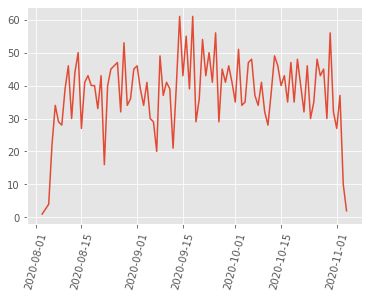

In [369]:
# And plot the number published each day
# I could see if there are trends by days of the week
plt.style.use('ggplot')
plt.plot(pub_by_date['number_published'])
plt.xticks(rotation=75)

In [370]:
# Categories looks at total published, likes, and dislikes.
# Only the news and politics have significant dislikes
categories = youtube_data[['category', 'title']].groupby('category').count().rename(columns={'title':'number_published'}).sort_values('number_published', ascending=False)


categories['likes'] = youtube_data[['category', 'likes']].groupby('category').sum()
categories['dislikes'] = youtube_data[['category', 'dislikes']].groupby('category').sum()
#opinions = pd.merge(likes, dislikes, on="category")

categories['total_opinions'] = categories['likes'] + categories['dislikes'] 
categories['% like'] = (categories['likes'] / categories['total_opinions']).map("{:.2%}".format)
categories['% dislike'] = (categories['dislikes'] / categories['total_opinions']).map("{:.2%}".format)

print('categories:')
categories

categories:


,number_published,likes,dislikes,total_opinions,% like,% dislike
category,,,,,,
Music,800,253649656,6675049,260324705,97.44%,2.56%
Entertainment,652,102964014,2082614,105046628,98.02%,1.98%
Sports,502,15807086,567632,16374718,96.53%,3.47%
Gaming,312,46234452,1308895,47543347,97.25%,2.75%
People & Blogs,270,36063104,1079302,37142406,97.09%,2.91%
Comedy,211,29436467,337696,29774163,98.87%,1.13%
Science & Technology,180,15719988,596887,16316875,96.34%,3.66%
News & Politics,153,2992971,516636,3509607,85.28%,14.72%
Howto & Style,149,11276522,344058,11620580,97.04%,2.96%


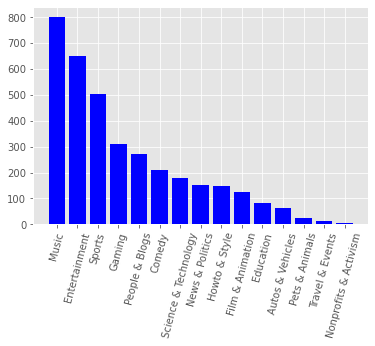

<Figure size 432x288 with 0 Axes>

In [531]:
# Plot number of vids in each category
# Someone could add the x labels.  I'm bad at it.
plt.style.use('ggplot')
x_axis = categories.index
y_axis = categories['number_published']
plt.bar(x_axis, y_axis, color='b' )
plt.xticks(rotation=75)
plt.show()
plt.savefig('Images/ViewsBar.png')  


In [373]:
# See if there are any trends by month.
# There are not.

month_stats = youtube_data[['date_published', 'title']].groupby(pd.Grouper(key='date_published',freq='M')).count()\
.rename(columns={'title':'published'})
month_stats['trending'] = youtube_data[['date_trending', 'title']].groupby(pd.Grouper(key='date_trending',freq='M')).count()
month_stats['views'] = youtube_data[['date_published', 'views']].groupby(pd.Grouper(key='date_published',freq='M')).sum()
print('month_stats:')
month_stats.set_index(pd.Index(['Aug', 'Sept', 'Oct', 'Nov']))

month_stats:


,published,trending,views
Aug,988,783,2941708021
Sept,1236,1221,3245012243
Oct,1240,1239,3672710940
Nov,76,297,131394571


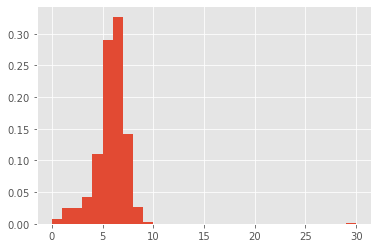

In [374]:
#See how long it takes a video to trend.
# We have a single outlier at 30 days, which we could chop off in subsequent work.
plt.style.use('ggplot')
lag_data = youtube_data['lag'].dt.days
plt.hist(lag_data, density=True, bins=30)
plt.show()

In [376]:
# Produce the most popular videos for a user

answer = 'Y'
while answer == 'Y':
    month = input('\n\nMonth for most liked videos (Aug, Sept, Oct, Nov)?')
    number = int(input('How many videos to see?'))
    month_data = youtube_data.loc[youtube_data['month_published']==month]
    month_sorted = month_data.sort_values('likes', ascending=False)
    print('Most popular videos:')
    vids = month_sorted.iloc[0:number,:]
    print(vids['title'])
    answer = input('Continue Y/N?')



Month for most liked videos (Aug, Sept, Oct, Nov)?Sept
How many videos to see?10
Most popular videos:
5782     [CHOREOGRAPHY] BTS (방탄소년단) 'Dynamite' Dance Pr...
13587           Justin Bieber - Holy ft. Chance The Rapper
10390    BTS (방탄소년단) 'Dynamite' Official MV (Choreograp...
6597     DJ Khaled ft. Drake - POPSTAR (Official Music ...
7948                              Stray Kids Back Door M/V
10474                                            BTS: IDOL
9370                         BTS: Tiny Desk (Home) Concert
9398             I Gave My 40,000,000th Subscriber 40 Cars
9593           Jack | Hoa Hải Đường | Official Music Video
8765                          Why I Haven’t Been Uploading
Name: title, dtype: object
Continue Y/N?N


## Plotting Process with Matplotlib/Pandas:
* Using the previously created PANDAS dataframe, created additional layers to parse specific data per month,
* This included trending categories and user statistics.
* Added supplemental grouby functions to organize this data. 
* Create bar and scatter graphs using pyplot. 
* The heatmap was created with a correlation function and seaborn.

In [377]:
#Coorelation between youtube scrubbed dat
youtube_coor = youtube_data.corr()
print(youtube_coor)

             views     likes  dislikes  comments
views     1.000000  0.904397  0.799704  0.731911
likes     0.904397  1.000000  0.777154  0.763838
dislikes  0.799704  0.777154  1.000000  0.725019
comments  0.731911  0.763838  0.725019  1.000000


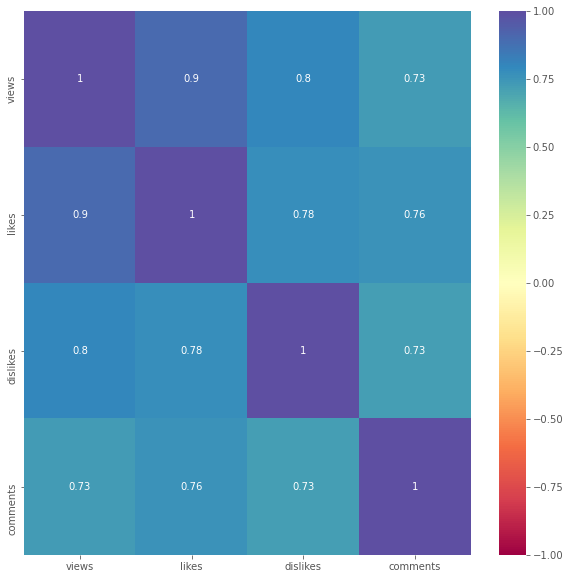

<Figure size 432x288 with 0 Axes>

In [532]:
#Coorelation heatmap using Seaborn
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(youtube_coor,annot=True,vmin=-1,vmax=1,cmap="Spectral")
plt.show()
plt.savefig('Images/ViewsHeat.png')  


In [379]:
#Extract Channel Views by Trending Month
channels = youtube_data[['channel','views','month_trending']]
channels.reset_index(drop=True,inplace=True)
channel_uni = channels.drop_duplicates(subset='channel', keep='first')
channel_uni.sort_values('month_trending')
channel_uni.reset_index(drop=True)
channel_ind = channel_uni.set_index("channel")
channel_ind

,views,month_trending
channel,,
Big Hit Labels,232649205,Aug
BLACKPINK,184778248,Sept
BANGTANTV,38303194,Oct
Cardi B,98442414,Aug
ArianaGrandeVevo,47606296,Oct
...,...,...
ポケモン公式YouTubeチャンネル,8548967,Oct
SUBWAY Restaurants,279416,Sept
FINAL FANTASY XIV,376833,Sept


In [380]:
#Classify Top Trending Channels by Month for August
aug_channels = channel_ind.loc[channel_ind["month_trending"] == "Aug"]
aug_scrub = aug_channels.nlargest(10,'views')
print(aug_scrub)
aug_scrub.head()

                           views month_trending
channel                                        
Big Hit Labels         232649205            Aug
Cardi B                 98442414            Aug
Ozuna                   45893190            Aug
DrakeVEVO               45086708            Aug
MileyCyrusVEVO          42667486            Aug
KQ ENTERTAINMENT        30059975            Aug
Nike                    29422403            Aug
ElAlfaElJefeTV          20288733            Aug
TREASURE (트레저)          19682753            Aug
Warner Bros. Pictures   19666039            Aug


,views,month_trending
channel,,
Big Hit Labels,232649205,Aug
Cardi B,98442414,Aug
Ozuna,45893190,Aug
DrakeVEVO,45086708,Aug
MileyCyrusVEVO,42667486,Aug


In [381]:
#Classify Top Trending Channels by Month for September
sept_channels = channel_ind.loc[channel_ind["month_trending"] == "Sept"]
sept_scrub = sept_channels.nlargest(10,'views')
print(sept_scrub)
sept_scrub.head()

                                        views month_trending
channel                                                     
BLACKPINK                           184778248           Sept
DJKhaledVEVO                         43394819           Sept
Stone Music Entertainment            41213361           Sept
J97                                  37422074           Sept
Brawl Stars                          32114735           Sept
MTV                                  29442683           Sept
Sech                                 28625426           Sept
CamiloVEVO                           26515286           Sept
CLC 씨엘씨 (Official YouTube Channel)   24613217           Sept
Daddy Yankee                         23452671           Sept


,views,month_trending
channel,,
BLACKPINK,184778248,Sept
DJKhaledVEVO,43394819,Sept
Stone Music Entertainment,41213361,Sept
J97,37422074,Sept
Brawl Stars,32114735,Sept


In [382]:
#Classify Top Trending Channels by Month for October
oct_channels = channel_ind.loc[channel_ind["month_trending"] == "Oct"]
oct_scrub = oct_channels.nlargest(10,'views')
print(oct_scrub)
oct_scrub.head()

                        views month_trending
channel                                     
The Pixel Kingdom    73728043            Oct
JustinBieberVEVO     57463872            Oct
SMTOWN               56531571            Oct
Apple                53596388            Oct
ArianaGrandeVevo     47606296            Oct
Zee Music Company    39142539            Oct
BANGTANTV            38303194            Oct
KarolGVEVO           23955265            Oct
Saturday Night Live  23841894            Oct
Hornstromp Games     23171453            Oct


,views,month_trending
channel,,
The Pixel Kingdom,73728043,Oct
JustinBieberVEVO,57463872,Oct
SMTOWN,56531571,Oct
Apple,53596388,Oct
ArianaGrandeVevo,47606296,Oct


In [383]:
#Classify Top Trending Channels by Month for November
nov_channels = channel_ind.loc[channel_ind["month_trending"] == "Nov"]
nov_scrub = nov_channels.nlargest(10,'views')
print(nov_scrub)
nov_scrub.head()

                      views month_trending
channel                                   
JYP Entertainment  74991178            Nov
Bad Bunny          33016615            Nov
HarryStylesVEVO    32844931            Nov
League of Legends  25327358            Nov
Myke Towers        19307359            Nov
James Charles      18529000            Nov
starshipTV         10898437            Nov
Marques Brownlee   10374991            Nov
charli d'amelio     9236725            Nov
Serie A             8961972            Nov


,views,month_trending
channel,,
JYP Entertainment,74991178,Nov
Bad Bunny,33016615,Nov
HarryStylesVEVO,32844931,Nov
League of Legends,25327358,Nov
Myke Towers,19307359,Nov


C:\Users\redea\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\redea\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\redea\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51200 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\redea\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\redea\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\redea\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 51200 missing from curre

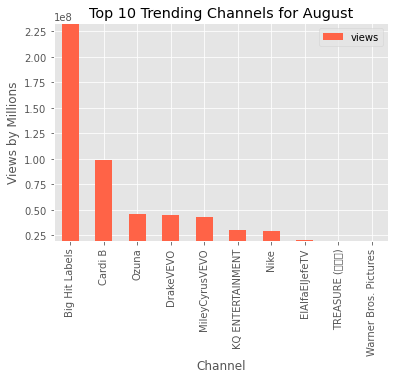

In [533]:
#Graph August
plt.style.use('ggplot')
aug_scrub.head(10).plot(kind="bar",facecolor="tomato")
aug_top = aug_scrub['views'].max()
aug_bottom = aug_scrub['views'].min()
aug_x_axis = aug_scrub.index
aug_y_axis = aug_scrub['views']
plt.ylim(aug_bottom,aug_top)
plt.title("Top 10 Trending Channels for August")
plt.ylabel("Views by Millions")
plt.xlabel("Channel")
plt.savefig('Images/ViewsCat1.png')  


Text(0.5, 0, 'Channel')

C:\Users\redea\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 50472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\redea\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 50648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\redea\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 50472 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\redea\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 50648 missing from current font.
  font.set_text(s, 0, flags=flags)


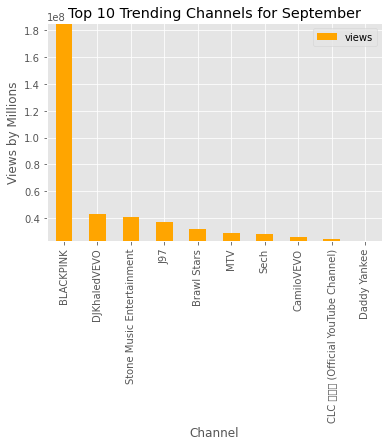

In [385]:
#Graph September
plt.style.use('ggplot')
sept_scrub.head(10).plot(kind="bar",facecolor="orange")
sept_top = sept_scrub['views'].max()
sept_bottom = sept_scrub['views'].min()
sept_x_axis = sept_scrub.index
sept_y_axis = sept_scrub['views']
plt.ylim(sept_bottom,sept_top)
plt.title("Top 10 Trending Channels for September")
plt.ylabel("Views by Millions")
plt.xlabel("Channel")
plt.savefig('Images/ViewsCat.png')  


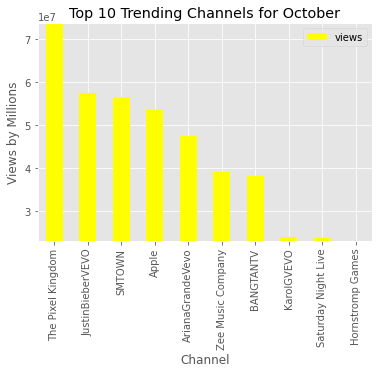

In [534]:
#Graph October
plt.style.use('ggplot')
oct_scrub.head(10).plot(kind="bar",facecolor="yellow")
oct_top = oct_scrub['views'].max()
oct_bottom = oct_scrub['views'].min()
oct_x_axis = oct_scrub.index
oct_y_axis = oct_scrub['views']
plt.ylim(oct_bottom,oct_top)
plt.title("Top 10 Trending Channels for October")
plt.ylabel("Views by Millions")
plt.xlabel("Channel")
plt.savefig('Images/ViewsCatY.png')  


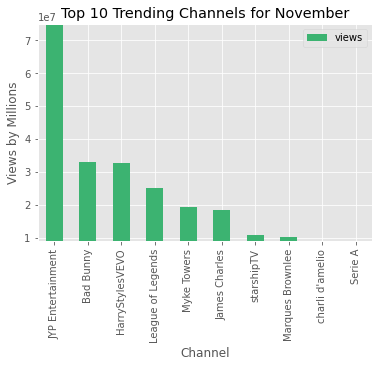

In [535]:
#Graph November
plt.style.use('ggplot')
nov_scrub.head(10).plot(kind="bar",facecolor="mediumseagreen")
nov_top = nov_scrub['views'].max()
nov_bottom = nov_scrub['views'].min()
nov_x_axis = nov_scrub.index
nov_y_axis = nov_scrub['views']
plt.ylim(nov_bottom,nov_top)
plt.title("Top 10 Trending Channels for November")
plt.ylabel("Views by Millions")
plt.xlabel("Channel")
plt.savefig('Images/ViewsCatG.png')  


In [389]:
#Prep
#create columns of percentage of likes and dislikes
df = youtube_data

df['tot_reaction'] = df['likes'] + df['dislikes'] + df['comments']
df['tot_sentements'] = df['likes'] + df['dislikes']
df['per_likes'] = round((df['likes']/df['tot_sentements']),2)
df['per_dislikes'] = round((df['dislikes']/df['tot_sentements']), 2)
youtube_data=df

In [390]:
#Prep
#df of the top 100
df=youtube_data
df_top100=df.sort_values(by='views', ascending=False)
df_top100=df_top100.head(100)

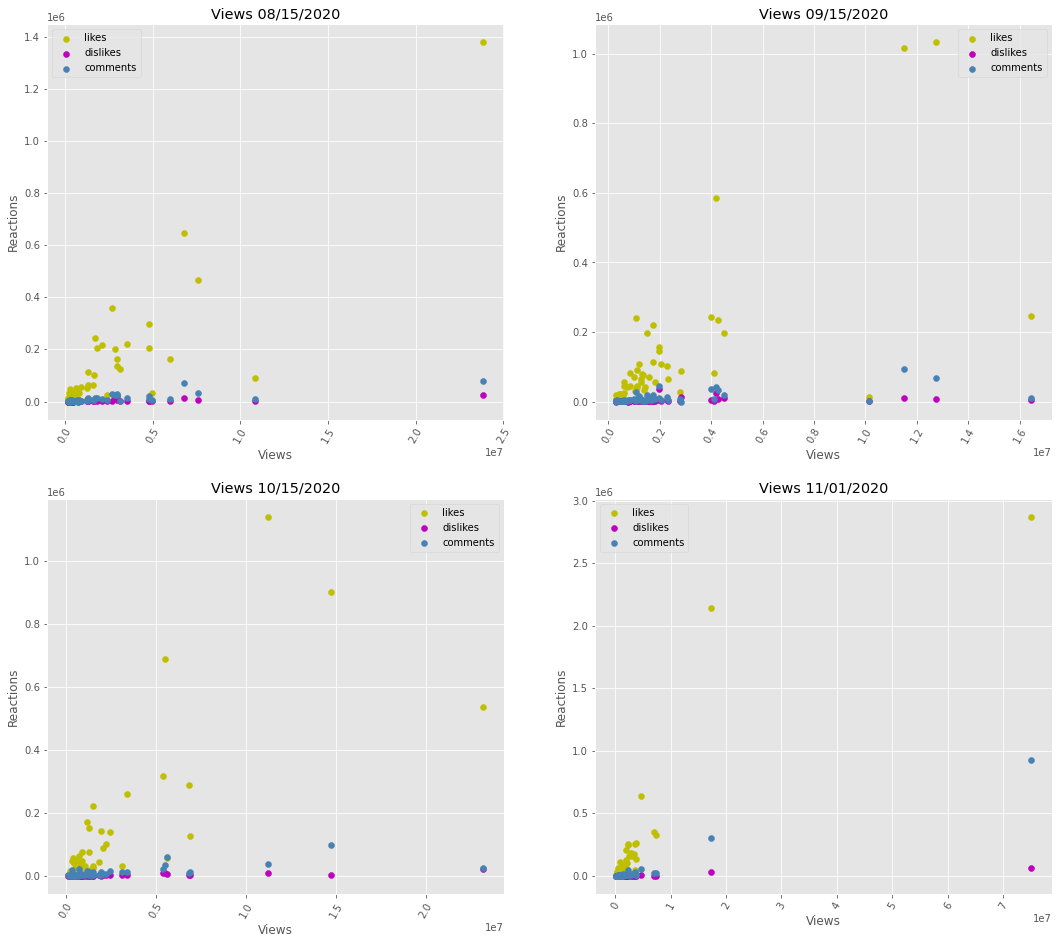

<Figure size 432x288 with 0 Axes>

In [536]:
#Scatter Plots of likes and dislikes on a date from all four months based on views
#not 100% convinced scatter plots work for this
#August starts on the 13th, full month of Sept and Oct, Nov is only 1-5th

#input_date = input(f'Enter a date to see what was trending that day example month/day/year')
#date=df[df['date_trending']==input_date]

#subplots initilizer
fig, (ax) = plt.subplots(2, figsize=(18, 16))
plt.style.use('ggplot')

#supplot 1
#initialize
df = youtube_data
#filter by specific day
df=df[df['date_trending']=='08/15/2020']
#subplot (rows, columns, locate)
ax = plt.subplot(2, 2, 1)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Views 08/15/2020', ylabel='Reactions', xlabel='Views')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 2
#initialize
df = youtube_data
#filter by specific day
df=df[df['date_trending']=='09/15/2020']
#subplot (rows, columns, locate)
ax = plt.subplot(2, 2, 2)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Views 09/15/2020', ylabel='Reactions', xlabel='Views')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)


#subplot 3
#initialize
df = youtube_data
#filter by specific day
df=df[df['date_trending']==' 10/15/2020']
#subplot (rows, columns, locate)
ax = plt.subplot(2, 2, 3)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Views 10/15/2020', ylabel='Reactions', xlabel='Views')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 4
#initialize
df = youtube_data
#filter by specific day
df=df[df['date_trending']==' 11/01/2020']
#subplot (rows, columns, locate)
ax = plt.subplot(2, 2, 4)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Views 11/01/2020', ylabel='Reactions', xlabel='Views')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.show()
plt.savefig('Images/ViewsCatagory.png')  



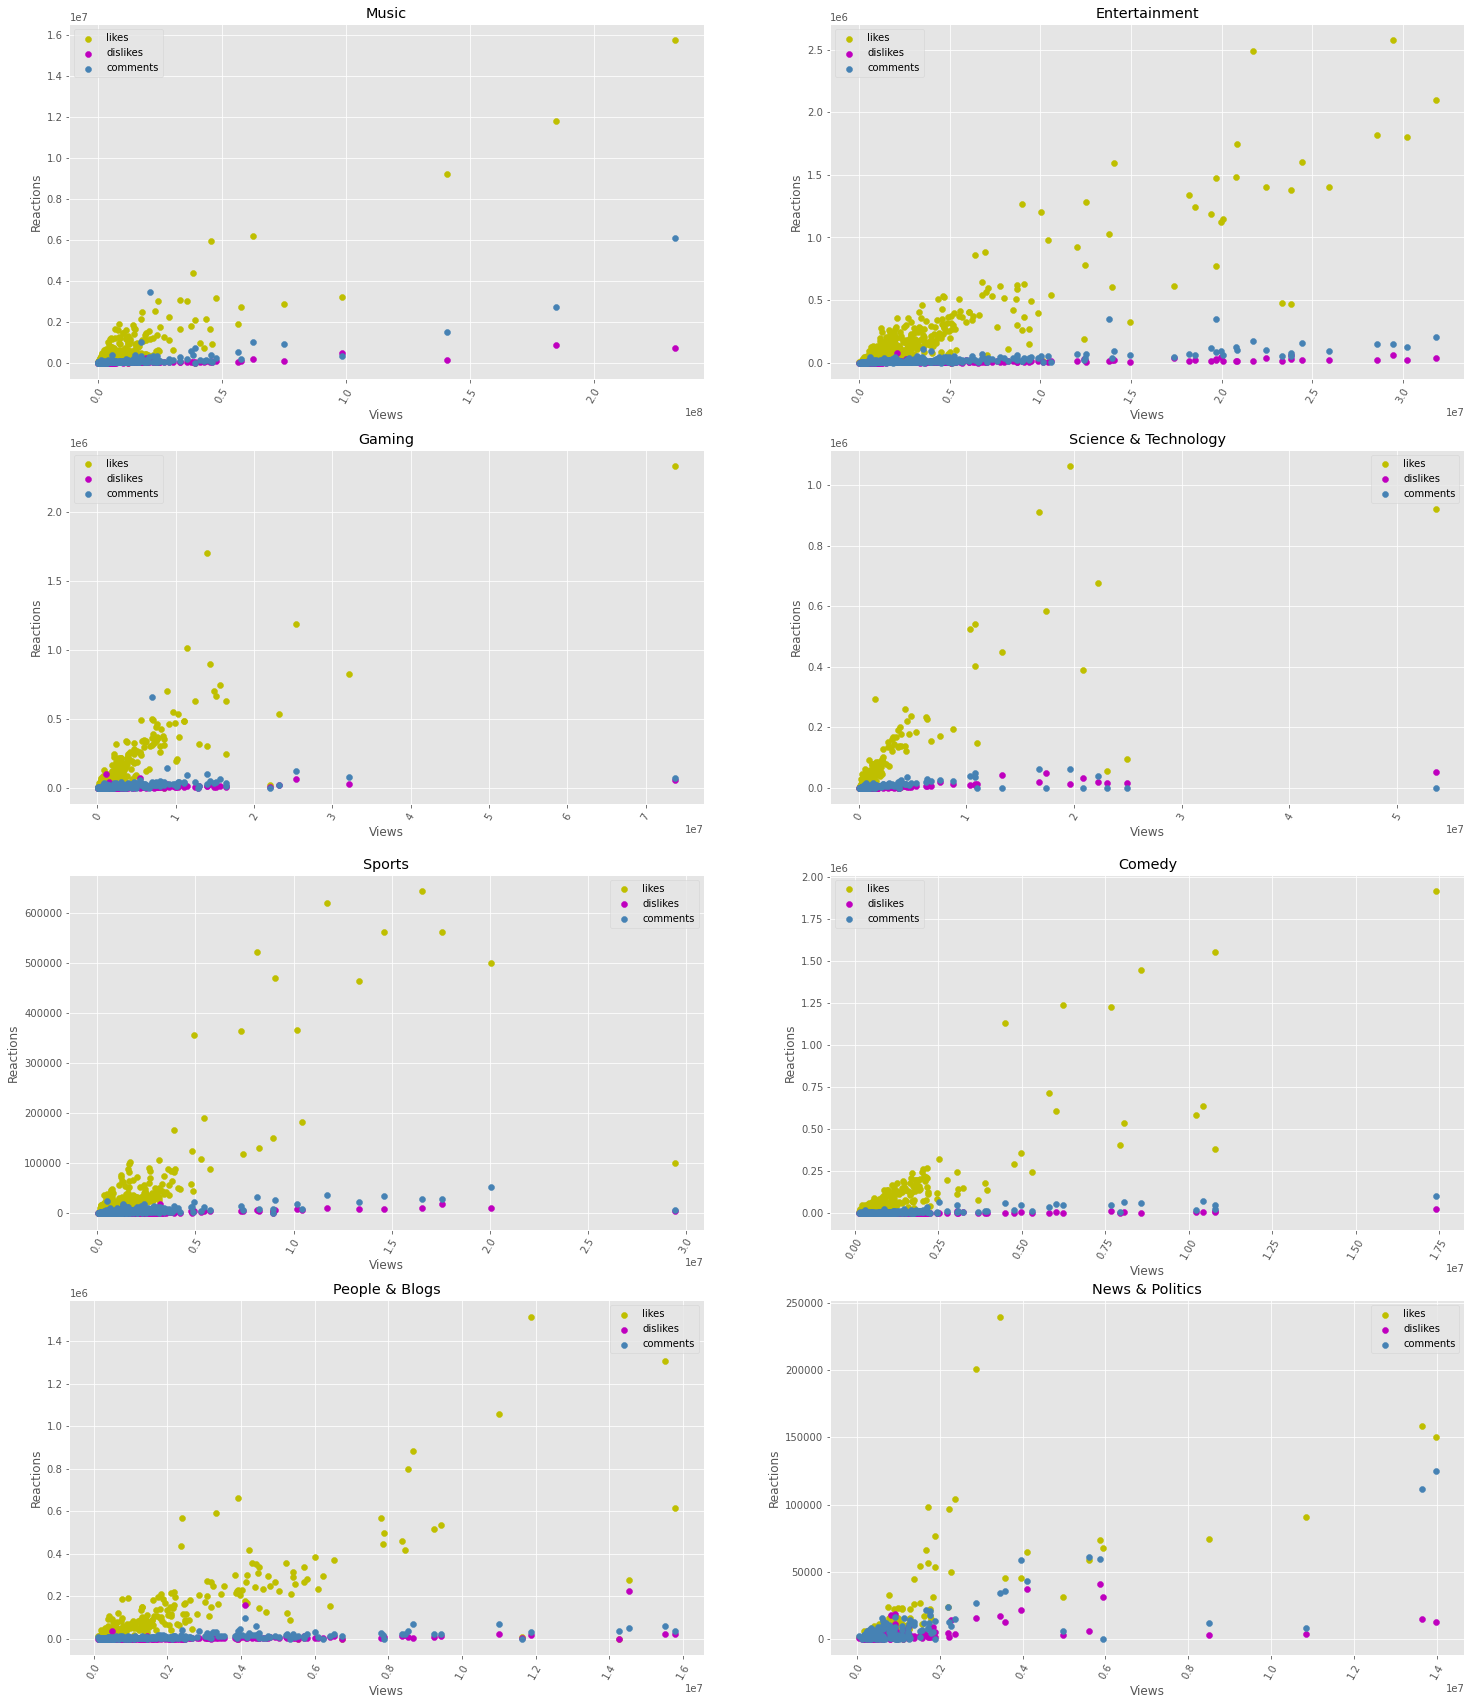

In [537]:
#scatter plots likes, dislikes and comments per category based on views
#top 8 categorys
#subplots initilizer
fig, (ax) = plt.subplots(2, figsize=(25, 30))
#format
plt.style.use('ggplot')
#supplot 1
#initialize
df = youtube_data
#filter by category
df=df[df['category']=='Music']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 1)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Music',  xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.savefig('Images/ViewsCat7.png')  


#subplot 2
#initialize
df = youtube_data
#filter  by category
df=df[df['category']=='Entertainment']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 2)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Entertainment', xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.savefig('Images/ViewsCat6.png')  


#subplot 3
#initialize
df = youtube_data
#filter by category
df=df[df['category']=='Gaming']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 3)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Gaming', xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 4
#initialize
df = youtube_data
#filter by category
df=df[df['category']=='Science & Technology']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 4)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Science & Technology', xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.savefig('Images/ViewsCat4.png')  


#subplot 5
#initialize
df = youtube_data
#filter  by category
df=df[df['category']=='Sports']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 5)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Sports', xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.savefig('Images/ViewsCat3.png')  


#subplot 6
#initialize
df = youtube_data
#filter by category
df=df[df['category']=='Comedy']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 6)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Comedy', xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.savefig('Images/ViewsCat2.png')  


#subplot 7
#initialize
df = youtube_data
#filter by category
df=df[df['category']=='People & Blogs']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 7)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='People & Blogs', xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.savefig('Images/ViewsCat1.png')  


#subplot 8
#initialize
df = youtube_data
#filter by category
df=df[df['category']=='News & Politics']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 8)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='News & Politics', xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.savefig('Images/ViewsCat.png')  

plt.show()


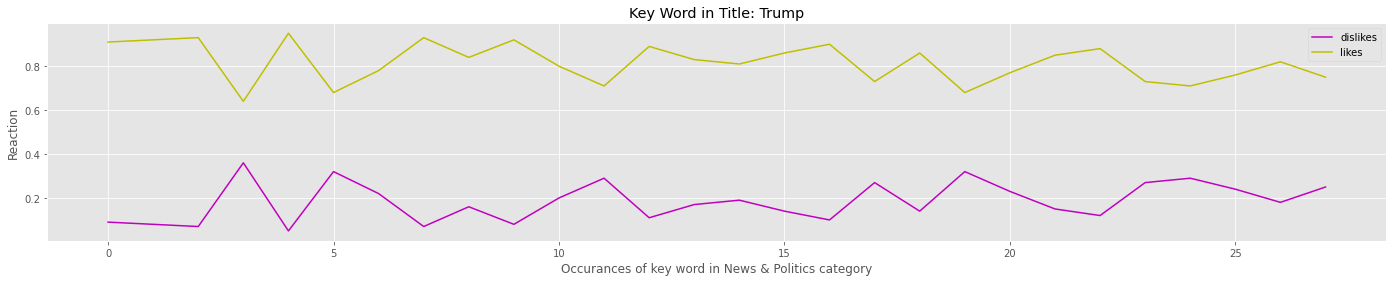

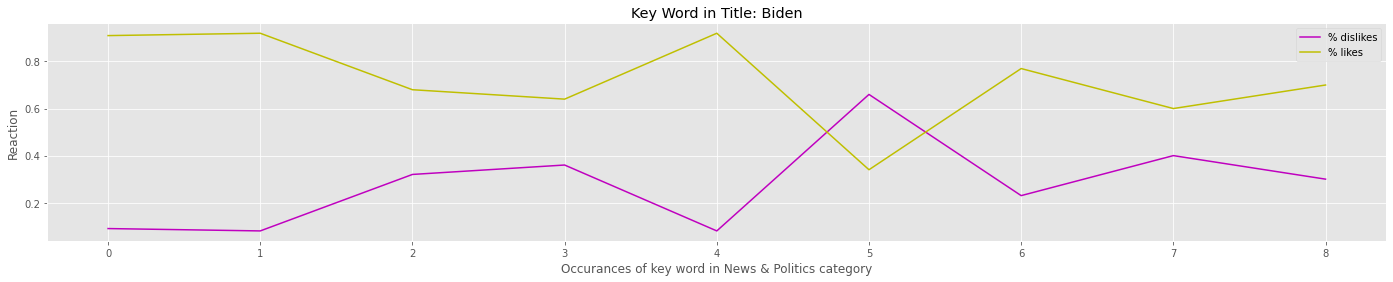

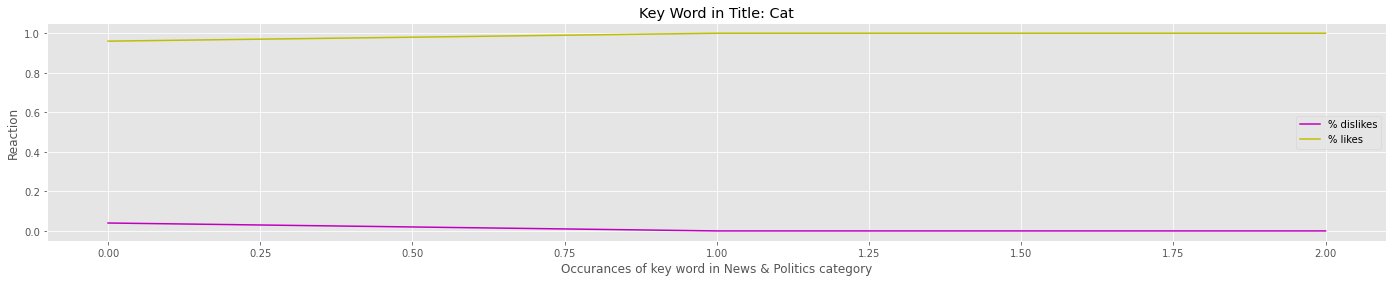

In [538]:
#Discord analsys: Shows reactions based on percet likes/dislikes if key term found in titles 
#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(24, 4))
#format
plt.style.use('ggplot')
#subplot 1
#initialize
df = youtube_data
#category filter
df=df[df['category']=='News & Politics']
#title filter: searches for key words in titles
df=df[df['title'].apply(lambda x : re.search('trump',x.lower()) !=None)]
#subplot x= 0 to lenght of dataframe, y= percent of like or dislike
ax.plot(range(len(df)), df['per_dislikes'], c='m')
ax.plot(range(len(df)), df['per_likes'], c='y')
ax.legend(['dislikes', 'likes'])
ax.set(title='Key Word in Title: Trump', ylabel='Reaction', xlabel='Occurances of key word in News & Politics category')

#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(24, 4))
#subplot 2
#initialize
df = youtube_data
#category filter
df=df[df['category']=='News & Politics']
#title filter: searches for key words in titles
df=df[df['title'].apply(lambda x : re.search('biden',x.lower()) !=None)]
#subplot x= 0 to lenght of dataframe, y= percent of like or dislike
ax.plot(range(len(df)), df['per_dislikes'], c='m')
ax.plot(range(len(df)), df['per_likes'], c='y')
ax.legend(['% dislikes', '% likes'])
ax.set(title='Key Word in Title: Biden', ylabel='Reaction', xlabel='Occurances of key word in News & Politics category')

#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(24, 4))
#subplot 2
#initialize
df = youtube_data
#category filter
df=df[df['category']=='People & Blogs']
#title filter: searches for key words in titles
df=df[df['title'].apply(lambda x : re.search('cat',x.lower()) !=None)]
#subplot x= 0 to lenght of dataframe, y= percent of like or dislike
ax.plot(range(len(df)), df['per_dislikes'], c='m')
ax.plot(range(len(df)), df['per_likes'], c='y')
ax.legend(['% dislikes', '% likes'])
ax.set(title='Key Word in Title: Cat', ylabel='Reaction', xlabel='Occurances of key word in News & Politics category')
plt.savefig('Images/reactions_Views.png')  

plt.show()


Enter a term to view percentage of likes and dislikes tas


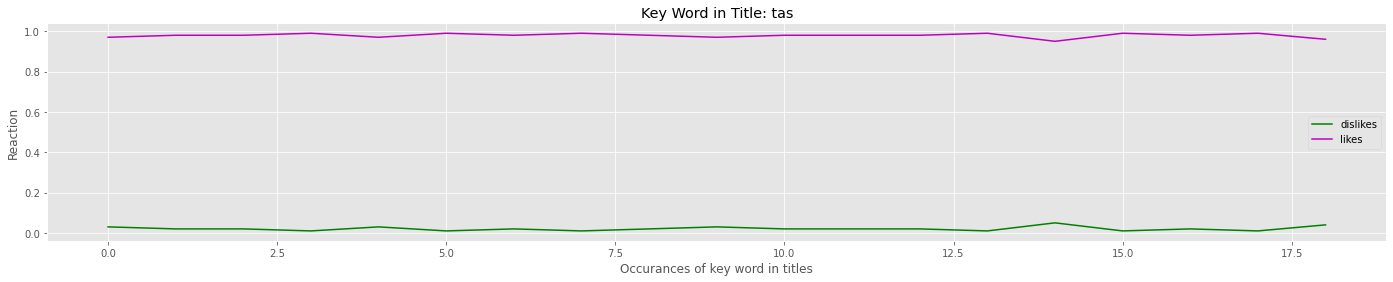

In [540]:
#User input key term search to see percentage likes and dislikes for a key term
#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(24, 4))
#format
plt.style.use('ggplot')
#subplot 2
#initialize
df = youtube_data
#category filter
#title filter: searches for key words in titles user input
input_term = input(f'Enter a term to view percentage of likes and dislikes ')

df=df[df['title'].apply(lambda x : re.search(input_term,x.lower()) !=None)]
#subplot
ax.plot(range(len(df)), df['per_dislikes'], c='g')
ax.plot(range(len(df)), df['per_likes'], c='m')
ax.legend(['dislikes', 'likes'])
ax.set(title=f'Key Word in Title: {input_term}') 
ax.set(ylabel='Reaction', xlabel='Occurances of key word in titles')
plt.savefig('Images/ViewsK.png')  

plt.show()

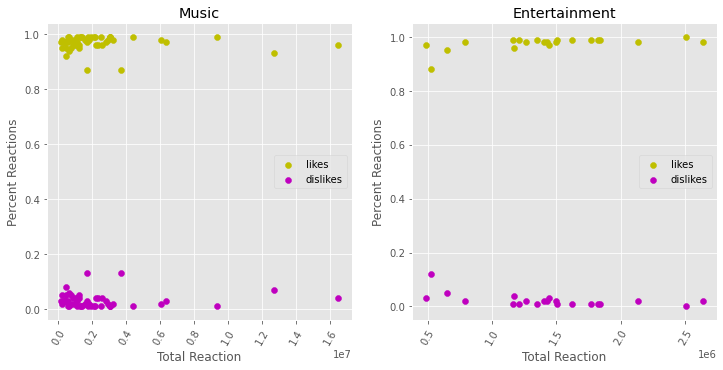

In [541]:
#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(12, 12))
#format
plt.style.use('ggplot')
#initialize
df = youtube_data
df = df_top100 
cat = 'Music' #filter by category
df=df[df['category']==cat ] 
ax = plt.subplot(2, 2, 1) #subplot (rows, columns, locate)
ax.scatter(df['tot_sentements'], df['per_likes'], color='y') 
ax.scatter(df['tot_sentements'], df['per_dislikes'], color='m') 
ax.set(title=f'{cat}', xlabel='Total Reaction', ylabel='Percent Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

df = df_top100 
cat = 'Entertainment' #filter by category
df=df[df['category']==cat ] 
ax = plt.subplot(2, 2, 2) #subplot (rows, columns, locate)
ax.scatter(df['tot_sentements'], df['per_likes'], color='y') 
ax.scatter(df['tot_sentements'], df['per_dislikes'], color='m') 
ax.set(title=f'{cat}', xlabel='Total Reaction', ylabel='Percent Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.savefig('Images/cat.png')  

plt.show()

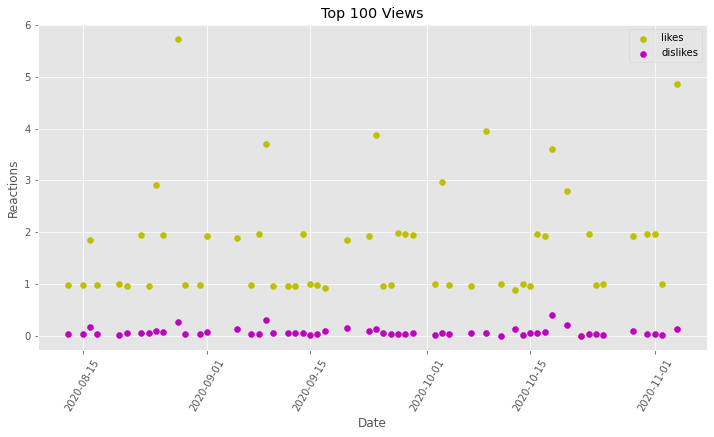

In [542]:
#Scatter of reactions of top 100 views and percent of likes and dislikes
#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(12, 6))
#format
plt.style.use('ggplot')
#initialize, group by date
df = df_top100.groupby('date_trending').sum() 
#subplot
ax = plt.subplot(1, 1, 1) #subplot (rows, columns, locate)
ax.scatter(df.index, df['per_likes'], color='y') 
ax.scatter(df.index, df['per_dislikes'], color='m')  
#labels
ax.set(title='Top 100 Views', xlabel='Date', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.savefig('Images/Top 100 Views.png')  
plt.show()

In [397]:
#export clean data
youtube_data.to_csv("youtube_data/youtube_data_clean.csv", index=False, header=True)

# EXPLORING YOUTUBE API:
* Collect data sample from YouTube API that contains top 50 most viewed YouTube videos in a month of 2019 and 2020.
* Also specifically look for top 50 Quarantine Challenges by view count during strict COVID Lockdown in US.



In [419]:
# Dependencies
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 
import os 
import wordcloud
import requests
from scipy import stats
from config import api_key
import googleapiclient.errors
import matplotlib as mpl
from cycler import cycler
import googleapiclient.discovery
from youtube_api import YoutubeDataApi
from googleapiclient.discovery import build

# API Exploration Process:
#### There are three kinds of data searches used: 
  * YouTube search, items with snippet descriptions
  * YouTube video, to get video statistics
  * youtube channel, to get channel statistic
  * all the above three files all linked by the unique video_id and channel_id field. 

### Relevant videos on youtube in April 2019:

In [445]:
#lookthrough youtube api and get top 50 relevant videos published between in April 2019
youtube = build("youtube", "v3", developerKey=api_key)
#set api_run_stop False to call the API/ True to skip the API
api_run_stop = True
if not api_run_stop:
    top50 = youtube.search().list(part=["snippet", "id"], 
                                  type="video", 
                                  publishedAfter="2019-04-01T00:00:00Z", 
                                  publishedBefore="2019-04-30T00:00:00Z", 
                                  videoDuration="any", 
                                  order="relevance", maxResults=50)
    top50= top50.execute()
#df_top50 is stored in SEARCH_DATA.json so no need to run the api everytime (solves the issue of running out of search quata)
    df_top50 = pd.DataFrame(top50['items'])
    df_top50.to_json('API_Search_Data/SEARCH_DATA_2019.json')
    top50_df_2019=pd.DataFrame(pd.read_json('API_Search_Data/SEARCH_DATA_2019.json'))
#print(json.dumps(top50, indent=4, sort_keys=True))

# Data Cleaning Process:
   #### Once we pulled the necessary data:
   * Stored the API data collected to a local folder so no need to run API everytime
   * Create dataframs 
   * Merge data sets based on the video ID and channel ID fields. 
   * Sorted  the data based on view count, number of likes and dislikes. 
   * Rename and rearrange for better readablility
   * Drop irrelevant columns

In [525]:
#df_video_ids, unpacks the dictionary stored in "id" and creats a data frame
df_video_ids = pd.json_normalize(top50_df_2019['id'])

#df_snippets, unpacks the dictionary stored in "snippet" and creats a data frame
df_snippets = pd.json_normalize(top50_df_2019['snippet']) 

#df_top50_merge, merges the above two data frames into one
df_top50_merge = pd.merge(df_video_ids , df_snippets, left_index=True, right_index=True)

#request, gets the 'videoId' and statistics from video api
videos = youtube.videos().list(part='id,statistics,snippet',id=list(df_top50_merge['videoId']), maxResults=50).execute() # json
#df_stat, creats a dataframe for items in response
videos_df = pd.DataFrame(videos['items']) # stat colum is list of dicts

#df_stat_clean, unpacks the dictionary stored in "statistics" and creats a data frame
videos_stat = pd.json_normalize(videos_df['statistics']) 

#df_stat_merge, merges the above two data frames into one (df_top50_merge & df_stat_clean) 
videos_merge = pd.merge(df_top50_merge, videos_stat, left_index=True, right_index=True)
videos_merge.fillna(0)
#convert time by calling the above function
youtube_date_parse(videos_merge, 'publishedAt', 'date_published', 'time_published', 'T', 'Z')                                       

clean_data_19= pd.DataFrame(videos_merge, columns=["date_published", "channelTitle", 
                                                   "title", "viewCount", "likeCount", 
                                                   "dislikeCount", "commentCount", 
                                                   "description"]) #.sort_values("viewCount", ascending=False)
#clean_data_19



In [526]:
#Creating df
top10_video = clean_df_19.iloc[0:10, lambda clean_df_19: [0, 1, 2, 3, 4, 5, 6]].sort_values("viewCount", ascending=True)
top10_video.head(5)

,date_published,channelTitle,title,viewCount,likeCount,dislikeCount,commentCount
9,2019-04-15,Virtual Railfan,"Belen, New Mexico USA - Virtual Railfan LIVE",5875955,9703,482,0
29,2019-04-28,DierenPark Amersfoort,Kijk live mee met de olifantenkudde in DierenP...,625233,311,44,0
38,2019-04-19,D5 Channel Punjabi,ਆਹ ਵੈਦ ਨੇ ਫੇਲ੍ਹ ਕੀਤੇ ਅਮਰੀਕਾ ਦੇ ਡਾਕਟਰ !,662423,11882,1215,685
45,2019-04-21,Duniya Today,Haye Mera Dil | DJ Remix || Full Vibration DJ ...,7161042,29089,2045,455
14,2019-04-17,Masteer Recipes,कैरीचं चटकदार लोणचं | Raw Mango Pickle | Kiric...,718067,6295,706,446


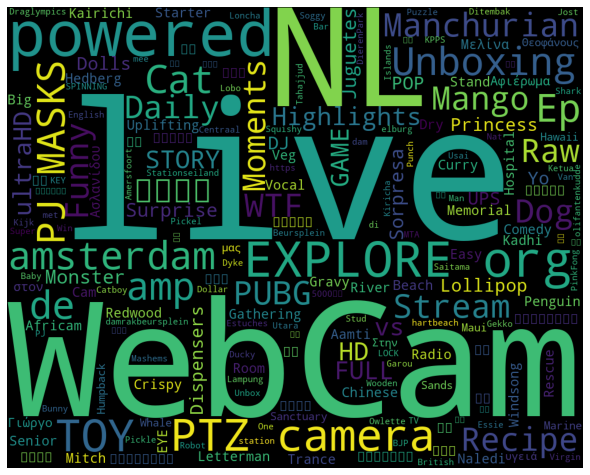

In [448]:
#creating wordcloud of words used in video titles 
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the file 
for val in clean_data_19["title"]: 
      
# type each val to string 
    val = str(val) 
  
# split the value 
    tokens = val.split() 
      
    comment_words += " ".join(tokens)+" "
       # to convert each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
        
wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('Images/top_viewed_Channels_19.png')  
plt.show() 

### Relevant videos on youtube in April 2020:

In [457]:
#lookthrough youtube api and get top 50 relevant videos published in April 2020

youtube = build("youtube", "v3", developerKey=api_key)
#set api_run_stop False to call the API/ True to skip the API
api_run_stop = True  
if not api_run_stop:
    top50 = youtube.search().list(part=["snippet", "id"],
                                  type="video", 
                                  publishedAfter="2020-04-01T00:00:00Z", 
                                  publishedBefore="2020-04-30T00:00:00Z",
                                  videoDuration="any", 
                                  order="relevance", 
                                  maxResults=50)
    top50= top50.execute()
#df_top50 is stored in SEARCH_DATA.json so no need to run the api everytime (solves the issue of running out of search quata)
    df_top50 = pd.DataFrame(top50['items'])
    df_top50.to_json('API_Search_Data/SEARCH_DATA_2020.json')
    top50_df_2020=pd.DataFrame(pd.read_json('API_Search_Data/SEARCH_DATA_2020.json')) 
#print(json.dumps(top50, indent=4, sort_keys=True))

# Data Cleaning:
* Create dataframs 
* Rename and rearrange for better readablility
* Mearge and drop irrelevant columns

In [500]:
#df_video_ids, unpacks the dictionary stored in "id" and creats a data frame
df_video_ids = pd.json_normalize(top50_df_2020['id'])

#df_snippets, unpacks the dictionary stored in "snippet" and creats a data frame
df_snippets = pd.json_normalize(top50_df_2020['snippet']) 

#df_top50_merge, merges the above two data frames into one
df_top50_merge = pd.merge(df_video_ids , df_snippets, left_index=True, right_index=True)

#request, gets the 'videoId' and statistics from video api
request = youtube.videos().list(part='id,statistics,snippet',id=list(df_top50_merge['videoId']))
response = request.execute()# json
#df_stat, creats a dataframe for items in response
df_stat = pd.DataFrame(response['items']) # stat colum is list of dicts

#df_stat_clean, unpacks the dictionary stored in "statistics" and creats a data frame
df_stat_clean = pd.json_normalize(df_stat['statistics']) 
#df_stat_merge, merges the above two data frames into one (df_top50_merge & df_stat_clean) 
df_stat_merge = pd.merge(df_top50_merge, df_stat_clean, left_index=True, right_index=True)
df_stat_merge.fillna(0)
#convert time by calling the above function
youtube_date_parse(videos_merge, 'publishedAt', 'date_published', 'time_published', 'T', 'Z')                                       

clean_df_20= pd.DataFrame(videos_merge, columns=["date_published", "channelTitle", 
                                                   "title", "viewCount", "likeCount", 
                                                   "dislikeCount", "commentCount", 
                                                   "description"]) #.sort_values("viewCount", ascending=False)
clean_df_20.head()

Already parsed, dumbass...


,date_published,channelTitle,title,viewCount,likeCount,dislikeCount,commentCount,description
0,2019-04-28,MaTeOWaNnA CoMeDy ReMaStErZ,Mitch Hedberg on Letterman - Stand Up Comedy 2...,28754,389,5,44,2019 Remaster of Mitch Hedberg on The Late Sho...
1,2019-04-03,Explore Dogs,Senior Dog Gathering Room powered by EXPLORE.org,1418395,5002,120,NaN,The gathering room at Old Friends Senior Dog S...
2,2019-04-02,Explore Zen Den,Redwood River Cam powered by EXPLORE.org,273869,2165,46,0,Watch as the Smith River weaves its way throug...
3,2019-04-08,Explore Birds Bats Bees,Penguin Beach powered by EXPLORE.org,549019,871,17,0,More than 20 Magellanic penguins live here at ...
4,2019-04-06,RazNitzanMusic,Vocal Trance Radio | Uplifting · 24/7 Live Stream,4856917,33914,1349,NaN,The music on our 24/7 Live Stream is also avai...


In [499]:
#create df
top10= clean_df_20.iloc[0:5, lambda clean_df_19: [0, 1, 2, 3, 4, 5, 6]].sort_values("viewCount", ascending=False)
top10

,date_published,channelTitle,title,viewCount,likeCount,dislikeCount,commentCount
3,2019-04-08,Explore Birds Bats Bees,Penguin Beach powered by EXPLORE.org,549019,871,17,0
4,2019-04-06,RazNitzanMusic,Vocal Trance Radio | Uplifting · 24/7 Live Stream,4856917,33914,1349,NaN
0,2019-04-28,MaTeOWaNnA CoMeDy ReMaStErZ,Mitch Hedberg on Letterman - Stand Up Comedy 2...,28754,389,5,44
2,2019-04-02,Explore Zen Den,Redwood River Cam powered by EXPLORE.org,273869,2165,46,0
1,2019-04-03,Explore Dogs,Senior Dog Gathering Room powered by EXPLORE.org,1418395,5002,120,NaN


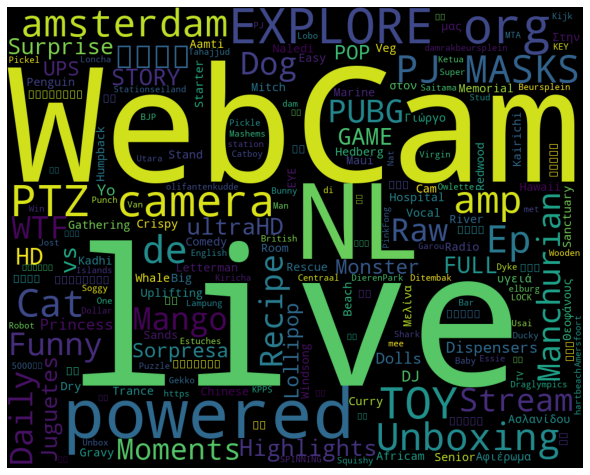

In [460]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the file 
for val in clean_df_20["title"]: 
      
# typecaste each val to string 
    val = str(val) 
  
# split the value 
    tokens = val.split()  
    comment_words += " ".join(tokens)+" "
        # to convert each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
  
wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('Images/top_viewed_Channels_20.png')
plt.show() 

# Top 50 Quarantine Challenges:
* During strict lockdown(03/15/2020 through 06/15/2020)

In [461]:
#youtube, looking through youtube api
youtube = build("youtube", "v3", developerKey=api_key)
#use api_run_stop, False calls the API/ True skips the API 
api_run_stop = True
if not api_run_stop:
    top50_qc = youtube.search().list(q="Quarantine Challenge",
                                     regionCode="US",
                                     part=["snippet", "id"],
                                     type="video",
                                     publishedAfter="2020-03-15T00:00:00Z", 
                                     publishedBefore="2020-06-15T00:00:00Z",
                                     videoDuration="any", 
                                     order="viewCount", 
                                     maxResults=50)
    top50_qc= top50_qc.execute()
    top50_qc_df = pd.DataFrame(top50_qc['items'])
    top50_qc_df.to_json('API_Search_Data/SEARCH_DATA_QC.json')
    top50_qc_df=pd.DataFrame(pd.read_json('API_Search_Data/SEARCH_DATA_QC.json')) 
#print(json.dumps(top50_qc, indent=4, sort_keys=True))

# Data Cleaning:
* Create dataframs 
* Rename and rearrange for better readablility
* Drop irrelevant columns

In [515]:
#df_video_ids, unpacks the dictionary stored in "id" and creats a data frame
df_video_ids = pd.json_normalize(top50_qc_df['id'])

#df_snippets, unpacks the dictionary stored in "snippet" and creats a data frame
df_snippets = pd.json_normalize(top50_qc_df['snippet'])

#df_top50_merge, merges the above two data frames into one
df_top50_merge = pd.merge(df_video_ids , df_snippets, left_index=True, right_index=True)

#request, gets the 'videoId' and statistics from video api
request = youtube.videos().list(part='id,statistics,snippet',id=list(df_top50_merge['videoId']))
response = request.execute()# json

df_stat = pd.DataFrame(response['items']) # response['items'] list of dicts

#df_stat_clean, unpacks the dictionary stored in "statistics" and creats a data frame
df_stat_clean = pd.json_normalize(df_stat['statistics']) 

# df_stat_merge, merges df_stat_clean with df_top50_merge
df_stat_merge = pd.merge(df_top50_merge, df_stat_clean, left_index=True, right_index=True)
#covert dtypes
df_stat_merge.convert_dtypes(infer_objects=True, convert_string=True, convert_integer=True, convert_boolean=True)
df_stat_merge.fillna(0)
#convert time by calling the above function
youtube_date_parse(df_stat_merge, 'publishedAt', 'date_published', 'time_published', 'T', 'Z')                                       

#qc_df_final, drop irrelevant columns to present cleaner dataframe
qc_df_final = df_stat_merge.drop(columns=['kind', 'liveBroadcastContent', 
                                          'publishTime', 'thumbnails.default.url', 'thumbnails.medium.width', 
                                          'thumbnails.medium.height', 'thumbnails.high.url', 'thumbnails.high.width', 
                                          'thumbnails.high.height', 'thumbnails.default.width', 'thumbnails.default.height', 
                                          'thumbnails.medium.url'])

qc_df_final.head()

#channels, gets the 'channelId' and statistics from youtube channels api
channels=youtube.channels().list(part='statistics',id=list(qc_df_final['channelId']), maxResults=50).execute()

#channels_df, creats a dataFrame of channels
channels_df = pd.DataFrame(channels['items'])

#channels_stat, unpack "statistics" into a dataFrame
channels_stat = pd.json_normalize(channels_df['statistics'])

#channels_merge, merge new stat with above df
channels_merge = pd.merge(qc_df_final, channels_stat, left_index=True, right_index=True)

#clean_data, rename columns for cleaner look
clean_data = channels_merge.rename(columns={"viewCount_x": "VideoViewCount", "viewCount_y": "channelViewCount", 
                                            "title": "VideoTitle", "commentCount_x": "Vid_commentCount"})
#drop columns for cleaner view
clean_data = clean_data.drop(columns=["hiddenSubscriberCount", "favoriteCount"])
#clean_data.head(50)

#clean_data_qc, displays a dataframe withcleaner order 
clean_data_qc = pd.DataFrame(clean_data, columns=["date_published", "channelTitle", 
                                                  "channelViewCount", "subscriberCount", 
                                                  "videoCount", "VideoTitle", "VideoViewCount", 
                                                  "likeCount", "dislikeCount", "commentCount", 
                                                  "description"]) #.sort_values("VideoViewCount", ascending=False) 
clean_data_qc.head(3)


,date_published,channelTitle,channelViewCount,subscriberCount,videoCount,VideoTitle,VideoViewCount,likeCount,dislikeCount,commentCount,description
0,2020-05-22,Diamond Platnumz,242264878,2460000,149,"Quarantine - Wasafi Feat Diamond Platnumz, Ray...",13275729,135419,12135,14390,Do You Think Your Quarantine Moves Are Better ...
1,2020-04-28,Chloe Ting,2682678123,9070000,2144,Get SNATCHED during Quarantine | Before After ...,5561286,202202,1293,8239,Here are some before after transformation jour...
2,2020-04-28,Trinity and Beyond,90023599,1420000,62,Hello Neighbor Steals Our Quarantine Games!!! ...,4031978,41975,3800,NaN,Hello Neighbor in Real Life Steals Our Play at...


In [527]:
#creat a df
top10_qc = clean_data_qc.iloc[0:25, lambda clean_df_19: [1, 2, 3, 4, 6, 7, 8, 9]]
top10_qc.head()

,channelTitle,channelViewCount,subscriberCount,videoCount,VideoViewCount,likeCount,dislikeCount,commentCount
0,Diamond Platnumz,242264878,2460000,149,13275729,135419,12135,14390
1,Chloe Ting,2682678123,9070000,2144,5561286,202202,1293,8239
2,Trinity and Beyond,90023599,1420000,62,4031978,41975,3800,NaN
3,SNOWTHAPRODUCT,221792933,2440000,287,2731322,82419,1639,10731
4,Renz Lesaca,7490996298,4070000,3253,2722530,34655,1684,1391


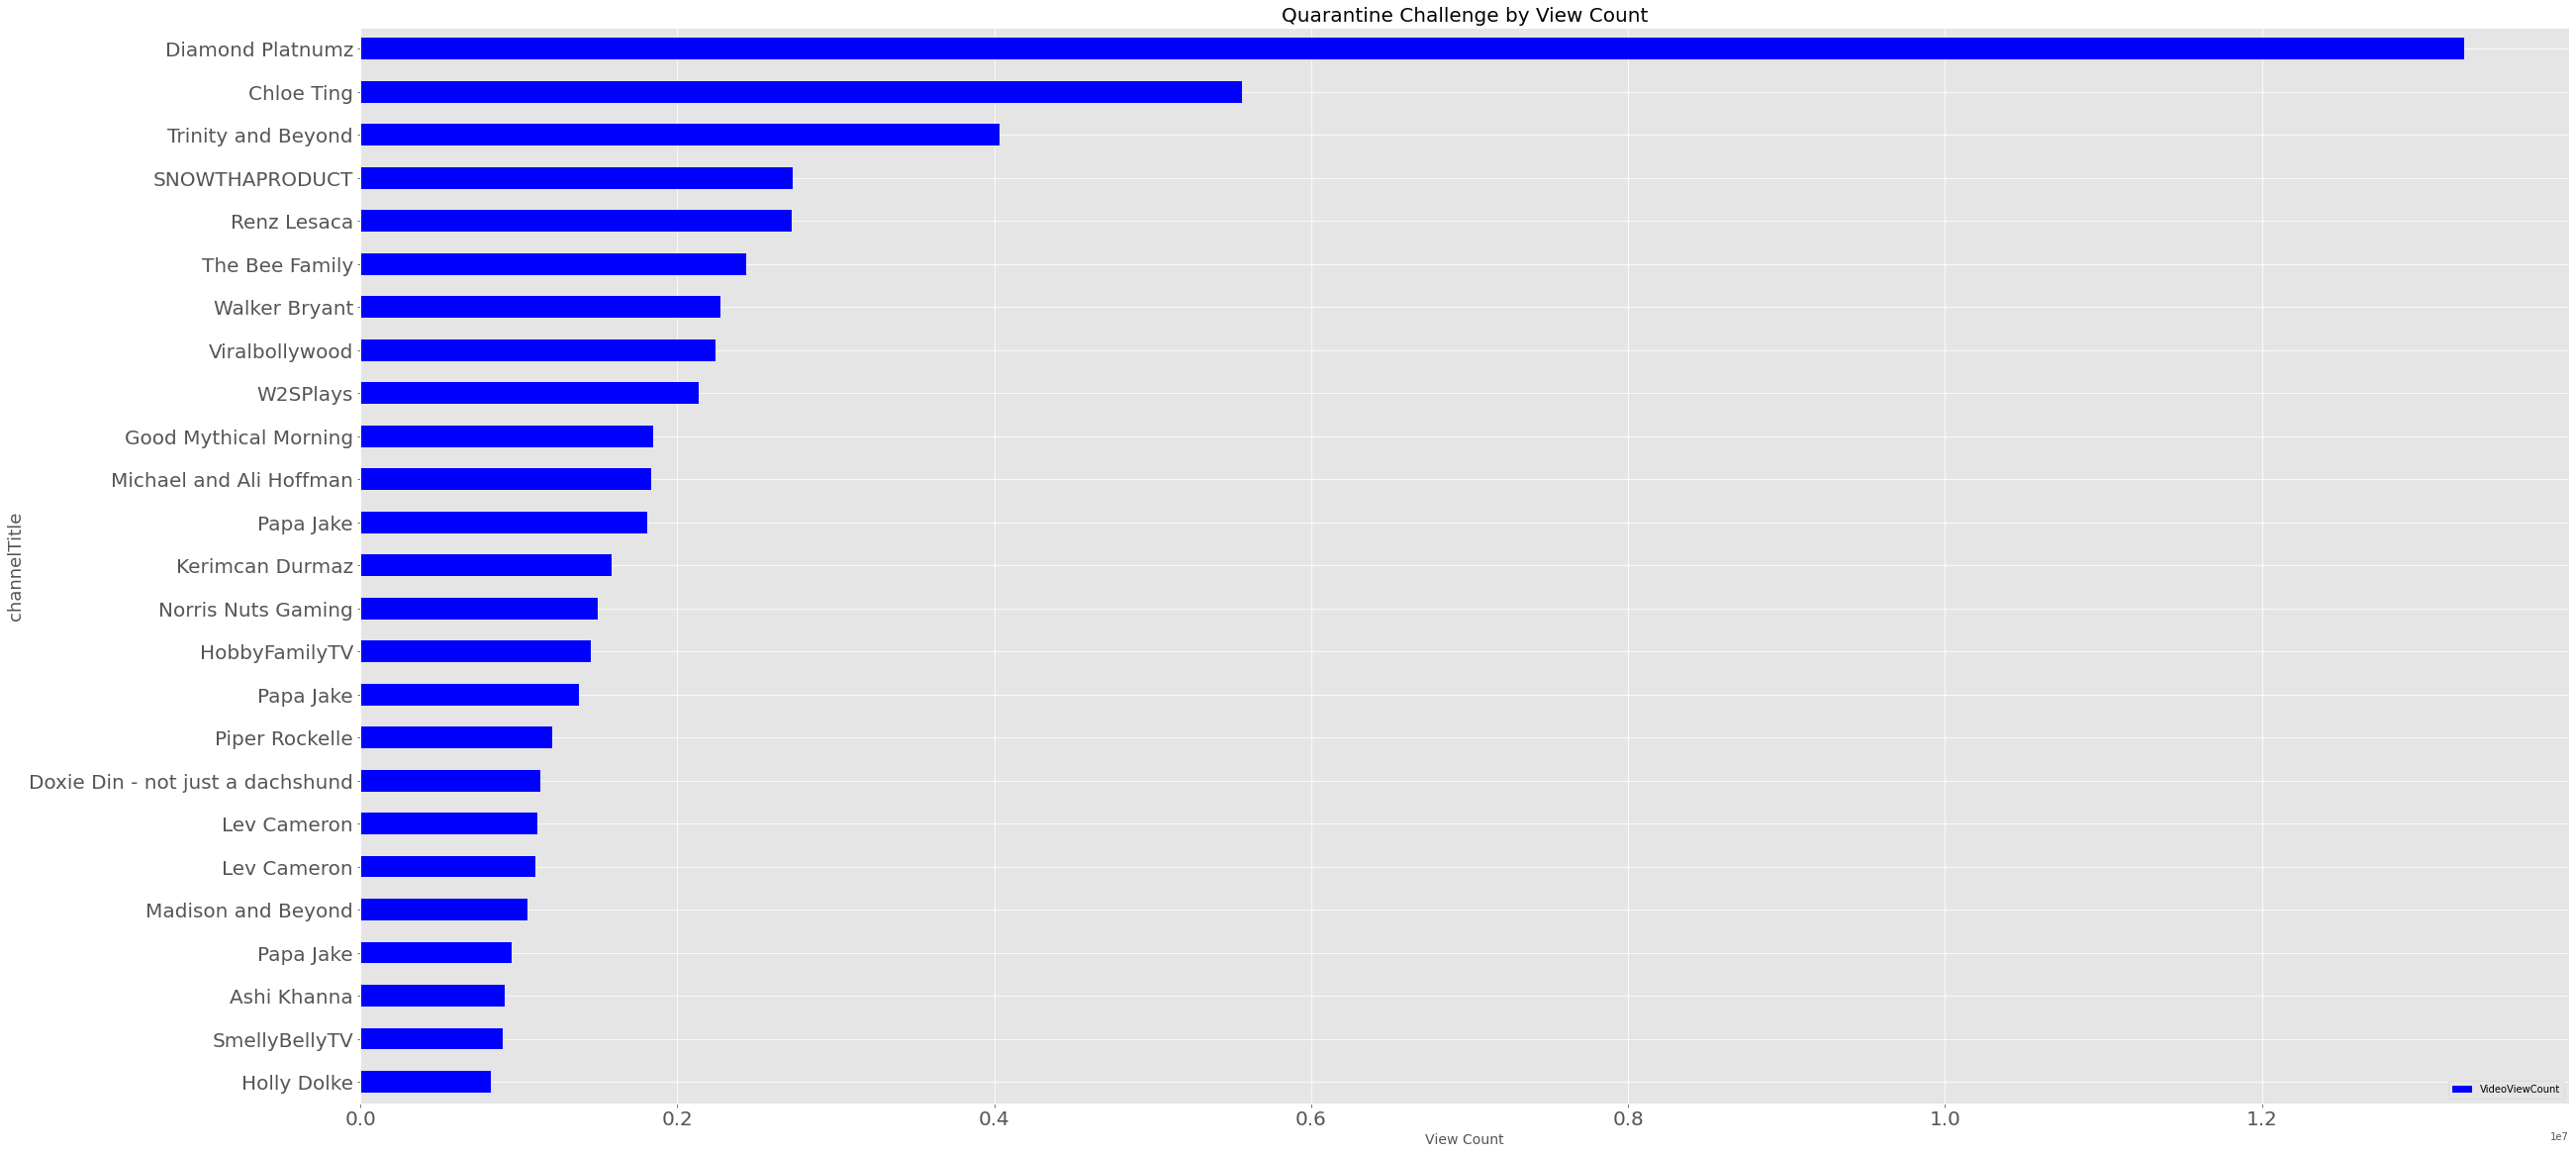

In [517]:
top_viewed = top10_qc
# Top quarantine challenge videos by view count
#top_viewed = top_viewed.sort_values('channelViewCount', ascending = False)
top_viewed.set_index('channelTitle', inplace=True)
top_viewed.VideoViewCount = top_viewed.VideoViewCount.astype("int64")

plot_pandas = top_viewed.sort_values('VideoViewCount', ascending = True).plot.barh(figsize=(40,20), color='blue',fontsize = 20)
plt.xlabel('View Count',fontsize = 14)
plt.ylabel('channelTitle',fontsize = 18)
plt.title('Quarantine Challenge by View Count',fontsize = 20)
plt.savefig('Images/top_viewed_QC.png', bbox_inches='tight')
plt.show()

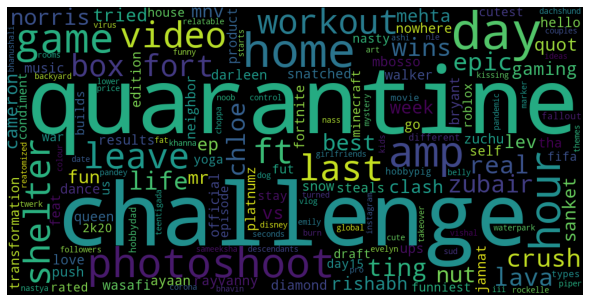

In [495]:
#create wordcloud 
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the file 
for val in clean_data_qc["VideoTitle"]: 
      
    # each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # to convert each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1000, height = 500, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig("Images/top_viewed_QC_wordcloud.png")
plt.show() 

In [501]:
#export clean data
clean_data_19.to_csv("Clean YT Data/clean_data_19.csv", index=False, header=True)
clean_data_20.to_csv("Clean YT Data/clean_data_20.csv", index=False, header=True)
clean_data_qc.to_csv("Clean YT Data/clean_data_qc.csv", index=False, header=True)